# Decision tree classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution. Use this as a starting point to fill in the meat of the project according to the outline in '[How to complete data science projects for submission](https://github.com/4GeeksAcademy/gperdrizet-ds7-materials/blob/main/how_to/complete_data-science_projects.md)'.

## 1. Data loading

### 1.1. Load

In [14]:
# Handle imports up-front
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import uniform, norm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")

### 1.2. Inspect

In [8]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 765 to 611
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


In [9]:
training_labels.info()

<class 'pandas.core.series.Series'>
Index: 614 entries, 765 to 611
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 9.6 KB


In [10]:
data_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 1.3. Train-test split

In [4]:
# Separate features from labels
labels=data_df['Outcome']
features=data_df.drop('Outcome', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=315
)

### 1.4. Encoding

In [4]:
# Your code here....

## 2. EDA

### 2.1. Baseline model performance

In [5]:
# Define a reusable helper function for cross-validation here. We are going to
# be doing a lot of cross-validation, this allows us to reuse this code
# without having to copy-paste it over and over.

def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross-validation accuracy: {(scores.mean() * 100):.2f} +/- {(scores.std() * 100):.2f}%')

    # Return the scores
    return scores

In [6]:
# Instantiate a random forest classifier model
model=DecisionTreeClassifier(random_state=315)

# Run the cross-validation
scores=cross_val(model, training_features, training_labels)

Cross-validation accuracy: 68.42 +/- 7.23%


### 2.2. Missing and/or extreme values

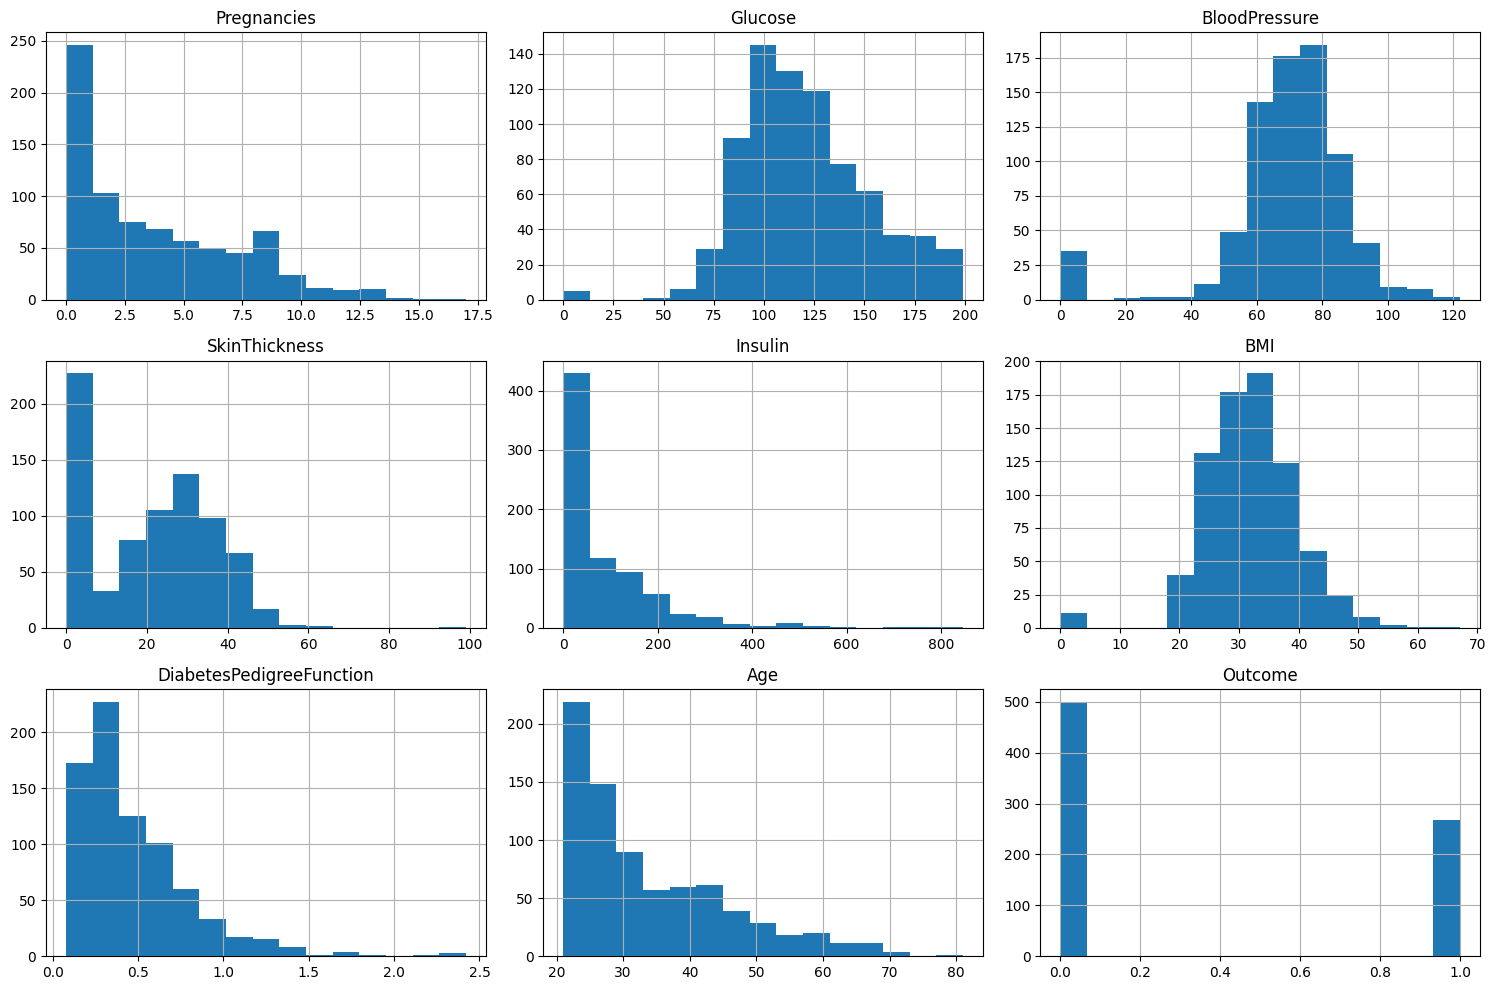

In [13]:
# Look at histograms for each feature
data_df.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.tight_layout()
plt.show()

In [11]:
# Check for / drop duplicates
print(f"Dimensions before dropping duplicates: {data_df.shape}")
data_df = data_df.drop_duplicates().reset_index(drop = True)
print(f"Dimensions after dropping duplicates: {data_df.shape}")

Dimensions before dropping duplicates: (768, 9)
Dimensions after dropping duplicates: (768, 9)


No duplicates to drop

In [12]:
# Check columns for 0 values
missing_data = (data_df == 0).sum()
missing_data

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

Several columns have 0 values. 
0 value for Pregnancies is irrelevant. 
0 value for BloodPressure (also Glucose and BMI?) would indicate death. 
SkinThickness and Insulin have the highest number of 0 values. 
Try to impute 0 values for all features except for Pregnancies and then check cross validation.

In [15]:
# Impute 0 values to the mean for desired columns
missing_data_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data_df[missing_data_features] = data_df[missing_data_features].replace(0, np.nan)
data_df[missing_data_features] = data_df[missing_data_features].fillna(data_df[missing_data_features].mean())
data_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [17]:
# Run the cross-validation after imputation (original accuracy: 68.42 +/- 7.23%)
scores=cross_val(model, training_features, training_labels)

Cross-validation accuracy: 68.42 +/- 7.23%


No improvement. Try scikit-learn imputer.

In [18]:
# Try scikit-learn imputer
from utils import impute

iterative_imputed_training_features, imp, qt=impute(training_features, missing_data_features)

ModuleNotFoundError: No module named 'seaborn'

### 2.3. Feature selection

In [ ]:
# Your code goes here...

## 3. Model training

In [10]:
# Your code goes here...

## 4. Model optimization

### 4.1. Hyperparameter optimization

In [ ]:
# from scipy.stats import uniform
# from sklearn.model_selection import RandomizedSearchCV

# Instantiate the model
model=DecisionTreeClassifier(random_state=315)

# Define the cross-validation strategy
cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

# Define the hyperparameter search space
distributions={
    'max_depth': list(range(1, 50)),
    'min_samples_split': list(range(5, 50)),
    'min_samples_leaf': list(range(5, 50))
}

# Set-up the search
search=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cross_validation,
    n_iter=50,
    random_state=315,
    return_train_score=True
)

results=search.fit(training_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

### 4.2. Cross-validation of optimized model

In [ ]:
# Your code goes here...

### 4.3. Final model evaluation

In [ ]:
# Your code goes here...